[View in Colaboratory](https://colab.research.google.com/github/cxl923cc/Avito/blob/master/Avito_Pipeline.ipynb)

# Avito Demand Prediction

**Step 1 - Preparation:**
  * Import the libraries.
  * Set up Kaggle API
  * Load train, test and feature files
  * Load russian stopwords

In [30]:
!pip install lightgbm
!pip install tqdm

    100% |████████████████████████████████| 51kB 4.9MB/s 


In [0]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
import zipfile
import cv2
from google.colab import files

from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn import preprocessing, model_selection, metrics

In [2]:
#@title
!pip install kaggle

  Running setup.py bdist_wheel for kaggle ... - \ done
  Stored in directory: /content/.cache/pip/wheels/98/be/57/a576a1f2f50f5c3bebd0c08fc3b2a6881dfde31c8217014978
Successfully built kaggle


In [3]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth
auth.authenticate_user()
drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])
filename = "/content/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)
request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [0]:
!kaggle competitions list

/bin/sh: 1: kaggle: not found


In [5]:
!kaggle competitions files -c avito-demand-prediction

name                    size  creationDate         
---------------------  -----  -------------------  
sample_submission.csv    8MB  2018-04-23 21:26:51  
test_jpg.zip            19GB  2018-04-23 22:09:42  
train_jpg.zip           49GB  2018-04-23 23:06:39  
test.csv.zip           107MB  2018-04-24 18:25:00  
periods_test.csv.zip   136MB  2018-04-24 18:25:02  
periods_train.csv.zip  170MB  2018-04-24 18:25:04  
train.csv.zip          308MB  2018-04-24 18:26:58  
test_active.csv.zip      2GB  2018-04-24 18:31:08  
train_active.csv.zip     3GB  2018-04-24 18:44:13  
train_jpg_4.zip         10GB  2018-05-01 22:40:01  
train_jpg_2.zip         10GB  2018-05-01 22:40:05  
train_jpg_1.zip         10GB  2018-05-01 22:40:06  
train_jpg_0.zip         10GB  2018-05-01 22:40:06  
train_jpg_3.zip         10GB  2018-05-01 22:40:06  


In [4]:
!kaggle competitions download -c avito-demand-prediction -f train.csv.zip
!unzip .kaggle/competitions/avito-demand-prediction/train.csv.zip
!kaggle competitions download -c avito-demand-prediction -f test.csv.zip
!unzip .kaggle/competitions/avito-demand-prediction/test.csv.zip
#After unzip, train.csv is under the home folder


train.csv.zip: Downloaded 308MB of 308MB
Archive:  .kaggle/competitions/avito-demand-prediction/train.csv.zip
  inflating: train.csv               
test.csv.zip: Downloaded 107MB of 107MB
Archive:  .kaggle/competitions/avito-demand-prediction/test.csv.zip
  inflating: test.csv                


In [5]:
!ls .kaggle/competitions/avito-demand-prediction/
!ls

test.csv.zip  train.csv.zip
datalab  test.csv  train.csv


In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
from google.colab import files

csv_import = drive.CreateFile({'id':'1taVHWV-xZ3BDyhewojBHc1GGqX0vi4Og'})
csv_import.GetContentFile('jpg_0.csv')

csv_import = drive.CreateFile({'id':'1_0KF6ii09a0zlUyCVUa5hb5smh2-ALBD'})
csv_import.GetContentFile('jpg_1.csv')

csv_import = drive.CreateFile({'id':'16hKDpvcw-rMNdBgbQV2Qj3Jk38Lgr2xs'})
csv_import.GetContentFile('jpg_2.csv')

csv_import = drive.CreateFile({'id':'13x8E4hIKv-g_7lyrBqaiDwDpRtMhvaSC'})
csv_import.GetContentFile('jpg_3.csv')

csv_import = drive.CreateFile({'id':'1eimUtnnWFxYB0ti68G6QnytGzdrP3GO6'})
csv_import.GetContentFile('jpg_4.csv')

csv_import = drive.CreateFile({'id':'1P5PHzBW6Uf9IOoAFqb8aAKe_DfdiqM7X'})
csv_import.GetContentFile('train_normal_text.csv')

csv_import = drive.CreateFile({'id':'1FPtGLkY8H4c2C55sRCslIq2a_9jMWEnQ'})
csv_import.GetContentFile('test_normal_text.csv')


In [8]:
jpg_0 = pd.read_csv('jpg_0.csv', index_col=0)
jpg_1 = pd.read_csv('jpg_1.csv', index_col=0)
jpg_2 = pd.read_csv('jpg_2.csv', index_col=0)
jpg_3 = pd.read_csv('jpg_3.csv', index_col=0)
jpg_4 = pd.read_csv('jpg_4.csv', index_col=0)
train_normal_text = pd.read_csv('train_normal_text.csv', index_col=0)
test_normal_text = pd.read_csv('test_normal_text.csv', index_col=0)

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [9]:
image_features = pd.concat([jpg_0, jpg_1, jpg_2, jpg_3, jpg_4], axis = 0, ignore_index = True)
image_features.describe().applymap('{:,.2f}'.format)

,flag_clear_img,image_size,image_shape_ratio
count,"1,390,832.00","1,390,832.00","1,390,832.00"
mean,0.18,"166,790.95",1.04
std,0.39,"31,078.61",0.41
min,0.00,"1,150.00",0.06
25%,0.00,"152,640.00",0.75
50%,0.00,"172,800.00",0.86
75%,0.00,"172,800.00",1.33
max,1.00,"230,400.00",22.07


**Step 2 - Read Data:**
  * Read train master file into a dataframe 'train_df'
  * Feature engineering
  * Merge image and text features onto train and test
  * Tf-idf vectorisation on train and test

In [10]:
train_df = pd.read_csv('train.csv')
train_df.head()

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,image,image_top_1,deal_probability
0,b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,NaN,NaN,Кокоби(кокон для сна),"Кокон для сна малыша,пользовались меньше месяц...",400.0,2,2017-03-28,Private,d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,1008.0,0.12789
1,2dac0150717d,39aeb48f0017,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,Другое,NaN,NaN,Стойка для Одежды,"Стойка для одежды, под вешалки. С бутика.",3000.0,19,2017-03-26,Private,79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...,692.0,0.00000
2,ba83aefab5dc,91e2f88dd6e3,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,"Видео, DVD и Blu-ray плееры",NaN,NaN,Philips bluray,"В хорошем состоянии, домашний кинотеатр с blu ...",4000.0,9,2017-03-20,Private,b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...,3032.0,0.43177
3,02996f1dd2ea,bf5cccea572d,Татарстан,Набережные Челны,Личные вещи,Товары для детей и игрушки,Автомобильные кресла,NaN,NaN,Автокресло,Продам кресло от0-25кг,2200.0,286,2017-03-25,Company,e6ef97e0725637ea84e3d203e82dadb43ed3cc0a1c8413...,796.0,0.80323
4,7c90be56d2ab,ef50846afc0b,Волгоградская область,Волгоград,Транспорт,Автомобили,С пробегом,ВАЗ (LADA),2110,"ВАЗ 2110, 2003",Все вопросы по телефону.,40000.0,3,2017-03-16,Private,54a687a3a0fc1d68aed99bdaaf551c5c70b761b16fd0a2...,2264.0,0.20797


In [49]:
#train_df.drop(['title', 'description'], axis = 1, inplace = True)
#train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1503424 entries, 0 to 1503423
Data columns (total 16 columns):
item_id                 1503424 non-null object
user_id                 1503424 non-null object
region                  1503424 non-null object
city                    1503424 non-null object
parent_category_name    1503424 non-null object
category_name           1503424 non-null object
param_1                 1441848 non-null object
param_2                 848882 non-null object
param_3                 640859 non-null object
price                   1418062 non-null float64
item_seq_number         1503424 non-null int64
activation_date         1503424 non-null object
user_type               1503424 non-null object
image                   1390836 non-null object
image_top_1             1390836 non-null float64
deal_probability        1503424 non-null float64
dtypes: float64(3), int64(1), object(12)
memory usage: 183.5+ MB


In [50]:
train_df.describe(include='O')

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,activation_date,user_type,image
count,1503424,1503424,1503424,1503424,1503424,1503424,1441848,848882,640859,1503424,1503424,1390836
unique,1503424,771769,28,1733,9,47,371,271,1219,21,3,1390836
top,6cc9ce5f3ab1,45ba3f23bf25,Краснодарский край,Краснодар,Личные вещи,"Одежда, обувь, аксессуары",Женская одежда,Обувь,Вторичка,2017-03-20,Private,2b2597c9ff4ae6326115df2e6966bb3125eee005dfae98...
freq,1,1080,141416,63638,697623,282753,226289,150450,50615,115190,1075706,1


In [0]:
# Merge image features
train_df = pd.merge(train_df, image_features, how = 'left', left_on = 'image', right_on = 'image_id')
train_df.drop(['image_id'], axis =1, inplace = True)
train_df['flag_image_missing'] = train_df['image'].isnull()*1
train_df.head()

In [59]:
train_df.describe().applymap('{:,.2f}'.format)

,price,item_seq_number,image_top_1,deal_probability,flag_clear_img,image_size,image_shape_ratio
count,"1,418,062.00","1,503,424.00","1,390,836.00","1,503,424.00","1,390,832.00","1,390,832.00","1,390,832.00"
mean,"316,708.09",743.67,"1,241.93",0.14,0.18,"166,790.95",1.04
std,"66,891,542.10","5,572.52",970.46,0.26,0.39,"31,078.61",0.41
min,0.00,1.00,0.00,0.00,0.00,"1,150.00",0.06
25%,500.00,9.00,425.00,0.00,0.00,"152,640.00",0.75
50%,"1,300.00",29.00,"1,057.00",0.00,0.00,"172,800.00",0.86
75%,"7,000.00",88.00,"2,217.00",0.15,0.00,"172,800.00",1.33
max,"79,501,011,850.00","204,429.00","3,066.00",1.00,1.00,"230,400.00",22.07


In [14]:
# Merge text columns (title and description) post normalisation
train_normal_text.columns = ['user_id', 'item_id', 'title_pn', 'description_pn']
train_df = pd.merge(train_df, train_normal_text[['item_id', 'title_pn', 'description_pn']], how = 'left', on = 'item_id')
train_df.head()

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,...,user_type,image,image_top_1,deal_probability,image_id,flag_clear_img,image_size,image_shape_ratio,title_pn,description_pn
0,b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,NaN,NaN,Кокоби(кокон для сна),...,Private,d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,1008.0,0.12789,d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,0.0,171840.0,0.745833,кокоби кокон для сон,кокон для сон малыш пользоваться маленький мес...
1,2dac0150717d,39aeb48f0017,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,Другое,NaN,NaN,Стойка для Одежды,...,Private,79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...,692.0,0.00000,79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...,0.0,172800.0,0.750000,стойка для одежда,стойка для одежда под вешалка с бутик
2,ba83aefab5dc,91e2f88dd6e3,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,"Видео, DVD и Blu-ray плееры",NaN,NaN,Philips bluray,...,Private,b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...,3032.0,0.43177,b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...,0.0,141120.0,1.088889,philips bluray,в хороший состояние домашний кинотеатр с blu r...
3,02996f1dd2ea,bf5cccea572d,Татарстан,Набережные Челны,Личные вещи,Товары для детей и игрушки,Автомобильные кресла,NaN,NaN,Автокресло,...,Company,e6ef97e0725637ea84e3d203e82dadb43ed3cc0a1c8413...,796.0,0.80323,e6ef97e0725637ea84e3d203e82dadb43ed3cc0a1c8413...,0.0,129600.0,1.000000,автокресло,продать кресло от0-25кг
4,7c90be56d2ab,ef50846afc0b,Волгоградская область,Волгоград,Транспорт,Автомобили,С пробегом,ВАЗ (LADA),2110,"ВАЗ 2110, 2003",...,Private,54a687a3a0fc1d68aed99bdaaf551c5c70b761b16fd0a2...,2264.0,0.20797,54a687a3a0fc1d68aed99bdaaf551c5c70b761b16fd0a2...,0.0,230400.0,1.777778,ваза 2110 2003,весь вопрос по телефон


In [12]:
test_df = pd.read_csv('test.csv')
test_df.head()

'''
total = test_df.isnull().sum().sort_values(ascending = False)
percent = (test_df.isnull().sum()/test_df.isnull().count()*100).sort_values(ascending = False)
missing_test_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_test_data
'''
# Merge image features
#test_df = pd.merge(test_df, test_image_features, how = 'left', left_on = 'image', right_on = 'image_id')
#test_df.drop(['image_id'], axis =1, inplace = True)
test_df['flag_image_missing'] = test_df['image'].isnull()*1
test_df.head()

# Merge text columns (title and description) post normalisation
test_normal_text.columns = ['user_id', 'item_id', 'title_pn', 'description_pn']
test_df = pd.merge(test_df, test_normal_text[['item_id', 'title_pn', 'description_pn']], how = 'left', on = 'item_id')

,Total,Percent
param_3,306331,60.249431
param_2,233229,45.871670
image,42609,8.380373
image_top_1,42609,8.380373
price,30585,6.015483
param_1,22910,4.505957
item_seq_number,0,0.000000
description,0,0.000000
title,0,0.000000
activation_date,0,0.000000


In [25]:
test_df.rename(columns = {'user_id_x':'user_id'}, inplace = True)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 508438 entries, 0 to 508437
Data columns (total 20 columns):
item_id                 508438 non-null object
user_id                 508438 non-null object
region                  508438 non-null object
city                    508438 non-null object
parent_category_name    508438 non-null object
category_name           508438 non-null object
param_1                 485528 non-null object
param_2                 275209 non-null object
param_3                 202107 non-null object
title                   508438 non-null object
description             508438 non-null object
price                   477853 non-null float64
item_seq_number         508438 non-null int64
activation_date         508438 non-null object
user_type               508438 non-null object
image                   465829 non-null object
image_top_1             465829 non-null float64
flag_image_missing      508438 non-null int64
title_pn                508438 non-null obj

In [55]:
test_df.describe(include='O')

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,activation_date,user_type,image
count,508438,508438,508438,508438,508438,508438,485528,275209,202107,508438,508438,508438,508438,465829
unique,508438,306069,28,1644,9,47,361,255,973,298039,485209,9,3,465829
top,42b5f175cac0,abcdd1ca1a5c,Краснодарский край,Екатеринбург,Личные вещи,"Одежда, обувь, аксессуары",Женская одежда,Обувь,Вторичка,Платье,В хорошем состоянии,2017-04-12,Private,d6080269821c937375618ada4b726a95dee6b502f094cd...
freq,1,496,45098,22391,216577,84896,66642,48776,18307,4673,918,81824,358259,1


In [38]:
import nltk
nltk.download('stopwords')
stopWords = stopwords.words('russian')
stopWords

[nltk_data] Downloading package stopwords to /content/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['и',
 'в',
 'во',
 'не',
 'что',
 'он',
 'на',
 'я',
 'с',
 'со',
 'как',
 'а',
 'то',
 'все',
 'она',
 'так',
 'его',
 'но',
 'да',
 'ты',
 'к',
 'у',
 'же',
 'вы',
 'за',
 'бы',
 'по',
 'только',
 'ее',
 'мне',
 'было',
 'вот',
 'от',
 'меня',
 'еще',
 'нет',
 'о',
 'из',
 'ему',
 'теперь',
 'когда',
 'даже',
 'ну',
 'вдруг',
 'ли',
 'если',
 'уже',
 'или',
 'ни',
 'быть',
 'был',
 'него',
 'до',
 'вас',
 'нибудь',
 'опять',
 'уж',
 'вам',
 'ведь',
 'там',
 'потом',
 'себя',
 'ничего',
 'ей',
 'может',
 'они',
 'тут',
 'где',
 'есть',
 'надо',
 'ней',
 'для',
 'мы',
 'тебя',
 'их',
 'чем',
 'была',
 'сам',
 'чтоб',
 'без',
 'будто',
 'чего',
 'раз',
 'тоже',
 'себе',
 'под',
 'будет',
 'ж',
 'тогда',
 'кто',
 'этот',
 'того',
 'потому',
 'этого',
 'какой',
 'совсем',
 'ним',
 'здесь',
 'этом',
 'один',
 'почти',
 'мой',
 'тем',
 'чтобы',
 'нее',
 'сейчас',
 'были',
 'куда',
 'зачем',
 'всех',
 'никогда',
 'можно',
 'при',
 'наконец',
 'два',
 'об',
 'другой',
 'хоть',
 'после',
 'на

In [53]:
### TFIDF Vectorizer ###
def text_f(ngram_min, ngram_max, num_SVD, textcol, train_df, test_df):
    tfidf_vec = TfidfVectorizer(ngram_range=(ngram_min,ngram_max), stop_words = stopWords)

    train_df[textcol] = train_df[textcol].fillna('_NA_')
    test_df[textcol] = test_df[textcol].fillna('_NA_')
    
    train_tfidf = tfidf_vec.fit_transform(train_df[textcol].values.tolist())
    test_tfidf = tfidf_vec.transform(test_df[textcol].values.tolist())

    ### SVD Components ###
    n_comp = num_SVD
    svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
    svd_obj.fit(train_tfidf)
    train_svd = pd.DataFrame(svd_obj.transform(train_tfidf))
    test_svd = pd.DataFrame(svd_obj.transform(test_tfidf))
    train_svd.columns = ['svd_'+textcol+'_'+str(i+1) for i in range(n_comp)]
    test_svd.columns = ['svd_'+textcol+'_'+str(i+1) for i in range(n_comp)]
    train_df = pd.concat([train_df, train_svd], axis=1)
    test_df = pd.concat([test_df, test_svd], axis=1)
    del train_tfidf, test_tfidf, train_svd, test_svd
    return train_df, test_df
train_df, test_df = text_f(1, 1, 3, 'title', train_df, test_df)
train_df, test_df = text_f(1, 1, 3, 'description', train_df, test_df)
train_df, test_df = text_f(1, 1, 3, 'title_pn', train_df, test_df)
train_df, test_df = text_f(1, 1, 3, 'description_pn', train_df, test_df)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1503424 entries, 0 to 1503423
Data columns (total 36 columns):
item_id                 1503424 non-null object
user_id                 1503424 non-null object
region                  1503424 non-null object
city                    1503424 non-null object
parent_category_name    1503424 non-null object
category_name           1503424 non-null object
param_1                 1441848 non-null object
param_2                 848882 non-null object
param_3                 640859 non-null object
title                   1503424 non-null object
description             1503424 non-null object
price                   1418062 non-null float64
item_seq_number         1503424 non-null int64
activation_date         1503424 non-null object
user_type               1503424 non-null object
image                   1390836 non-null object
image_top_1             1390836 non-null float64
deal_probability        1503424 non-null float64
flag_clear_img         

In [85]:
#Price, Image_top_1
def other_f(df):
    
    df['flag_price_missing'] = df["price"].isnull()*1
    df["price_log"] = np.log(df["price"]+0.001)
    df["price_log"].fillna(-999,inplace=True)
    
    df["image_top_1"].fillna(-999,inplace=True)
    
    df['activation_date'] = pd.to_datetime(df['activation_date'])
    df["weekday"] = df['activation_date'].dt.weekday
    df["weekofyear"] = df['activation_date'].dt.week
    df["dayofmonth"] = df['activation_date'].dt.day
    
    print("\nEncode Variables")
    categorical = ["region", "city", "parent_category_name", "category_name", "user_type", "param_1", "param_2", "param_3"]
    # , "image_top_1"]
    print("Encoding :",categorical)
    # Encoder:
    lbl = preprocessing.LabelEncoder()
    for col in categorical:
        df[col] = lbl.fit_transform(df[col].astype(str))
    
other_f(train_df)
other_f(test_df)


Encode Variables
Encoding : ['param_1', 'param_2', 'param_3']

Encode Variables
Encoding : ['param_1', 'param_2', 'param_3']


**Step 3 - Training and Validation:**
  * lightgbm with 5-fold Cross Validation


In [100]:
#train_df['dayofmonth'].value_counts()
#test_df['dayofmonth'].value_counts()

20    115190
27    114863
19    114416
26    113513
28    112885
21    110535
22    109813
15    108615
23    106544
16    106168
17     98773
18     97554
24     97351
25     97104
29        87
2          3
1          3
30         3
3          2
7          1
31         1
Name: dayofmonth, dtype: int64

In [101]:
#Specify the features
tabular_cols = ['flag_price_missing', 'price_log']
time_cols = ['weekday', 'dayofmonth']
encode_cols = ['region', 'city', 'parent_category_name', 'category_name', 'item_seq_number', 'user_type']
text_cols = ['svd_title_1', 'svd_title_2', 'svd_title_3', 'svd_description_1', 'svd_description_2', 'svd_description_3', "param_1", "param_2", "param_3"]
image_cols = ['image_top_1', 'flag_image_missing']

select_cols = tabular_cols + time_cols + encode_cols + text_cols + image_cols

train_df[select_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1503424 entries, 0 to 1503423
Data columns (total 21 columns):
flag_price_missing      1503424 non-null int64
price_log               1503424 non-null float64
weekday                 1503424 non-null int64
dayofmonth              1503424 non-null int64
region                  1503424 non-null int64
city                    1503424 non-null int64
parent_category_name    1503424 non-null int64
category_name           1503424 non-null int64
item_seq_number         1503424 non-null int64
user_type               1503424 non-null int64
svd_title_1             1503424 non-null float64
svd_title_2             1503424 non-null float64
svd_title_3             1503424 non-null float64
svd_description_1       1503424 non-null float64
svd_description_2       1503424 non-null float64
svd_description_3       1503424 non-null float64
param_1                 1503424 non-null int64
param_2                 1503424 non-null int64
param_3                 150

In [102]:
#Specify the parameters
params = {
    "objective" : "regression",
    "metric" : "rmse",
    "num_leaves" : 30,
    "learning_rate" : 0.1,
    "bagging_fraction" : 0.7,
    "feature_fraction" : 0.7,
    "bagging_frequency" : 5,
    "bagging_seed" : 2018,
    "verbosity" : -1
    }


from sklearn.cross_validation import KFold


  
def run_kfold(k, X_all, y_all, max_iteration, early_stop_iteration):
    kf = KFold(train_df.shape[0], n_folds=k)
    outcomes = []
    eval_summary = []
    fold = 0
    for train_index, valid_index in kf:
        fold += 1
        X_train, X_valid = X_all.values[train_index], X_all.values[valid_index]
        y_train, y_valid = y_all.values[train_index], y_all.values[valid_index]
        lgtrain = lgb.Dataset(X_train, label=y_train)
        lgval = lgb.Dataset(X_valid, label=y_valid)
        evals_result = {}
        model = lgb.train(params, lgtrain, max_iteration, valid_sets=[lgval], early_stopping_rounds=early_stop_iteration, verbose_eval=50, evals_result=evals_result)
        print("Fold {0} best iteration: {1}".format(fold, model.best_iteration))
        
        rmse = np.sqrt(metrics.mean_squared_error(y_valid, model.predict(X_valid, num_iteration=model.best_iteration)))
        print("Fold {0} rmse: {1}".format(fold, rmse))  
        
        outcomes.append(rmse)
        eval_summary.append(evals_result)
           
    mean_outcome = np.mean(outcomes)
    std_outcome = np.std(outcomes)
    print("Mean RMSE: {0}; Std RMSE {1}".format(mean_outcome, std_outcome)) 
    return eval_summary
    
    #return model, evals_result

eval_summary = run_kfold(k = 5, X_all = train_df[select_cols], y_all = train_df['deal_probability'], max_iteration = 1000, early_stop_iteration = 100)
#pd.DataFrame(dict(zip(['fold 0', 'fold 1', 'fold 2', 'fold 3', 'fold 4'], eval_summary))).plot.line()

Training until validation scores don't improve for 100 rounds.
[50]	valid_0's rmse: 0.232062
[100]	valid_0's rmse: 0.230113
[150]	valid_0's rmse: 0.229196
[200]	valid_0's rmse: 0.228599
[250]	valid_0's rmse: 0.228232
[300]	valid_0's rmse: 0.227879
[350]	valid_0's rmse: 0.227598
[400]	valid_0's rmse: 0.2273
[450]	valid_0's rmse: 0.227099
[500]	valid_0's rmse: 0.22693
[550]	valid_0's rmse: 0.226803
[600]	valid_0's rmse: 0.226643
[650]	valid_0's rmse: 0.226497
[700]	valid_0's rmse: 0.226369
[750]	valid_0's rmse: 0.226233
[800]	valid_0's rmse: 0.22614
[850]	valid_0's rmse: 0.226056
[900]	valid_0's rmse: 0.225985
[950]	valid_0's rmse: 0.225926
[1000]	valid_0's rmse: 0.225866
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 0.225866
Fold 1 best iteration: 1000
Fold 1 rmse: 0.22586565420024468
Training until validation scores don't improve for 100 rounds.
[50]	valid_0's rmse: 0.23194
[100]	valid_0's rmse: 0.230044
[150]	valid_0's rmse: 0.229133
[200]	valid_0's rmse: 0.22

[350]	valid_0's rmse: 0.227768
[400]	valid_0's rmse: 0.227535
[450]	valid_0's rmse: 0.227284
[500]	valid_0's rmse: 0.22715
[550]	valid_0's rmse: 0.226964
[600]	valid_0's rmse: 0.226839
[650]	valid_0's rmse: 0.226683
[700]	valid_0's rmse: 0.226563
[750]	valid_0's rmse: 0.226425
[800]	valid_0's rmse: 0.226342
[850]	valid_0's rmse: 0.226242
[900]	valid_0's rmse: 0.226151
[950]	valid_0's rmse: 0.226061
[1000]	valid_0's rmse: 0.226
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 0.226
Fold 4 best iteration: 1000
Fold 4 rmse: 0.22600047550587093
Training until validation scores don't improve for 100 rounds.
[50]	valid_0's rmse: 0.232388
[100]	valid_0's rmse: 0.230411
[150]	valid_0's rmse: 0.22958
[200]	valid_0's rmse: 0.228922
[250]	valid_0's rmse: 0.228473
[300]	valid_0's rmse: 0.228174
[350]	valid_0's rmse: 0.227889
[400]	valid_0's rmse: 0.227596
[450]	valid_0's rmse: 0.227371
[500]	valid_0's rmse: 0.227179
[550]	valid_0's rmse: 0.227034
[600]	valid_0's rmse: 0.22688

TypeError: ignored

In [107]:
# Create predictions on test
%%time
lgtrain = lgb.Dataset(train_df[select_cols], label=train_df['deal_probability'])
model_final = lgb.train(params, lgtrain, num_boost_round=1000, verbose_eval=50)
pred_test_y = model_final.predict(test_df[select_cols])


CPU times: user 3min 43s, sys: 1.73 s, total: 3min 45s
Wall time: 1min 53s


In [108]:
%%time
version = 'v3'
lgsub = pd.DataFrame(pred_test_y,columns=["deal_probability"], index=test_df.item_id)
lgsub['deal_probability'].clip(0.0, 1.0, inplace=True) # Between 0 and 1
lgsub.to_csv('sub_'+version+'.csv',index=True,header=True)
lgsub.head()
files.download('sub_'+version+'.csv')

CPU times: user 1.66 s, sys: 93 ms, total: 1.76 s
Wall time: 1min


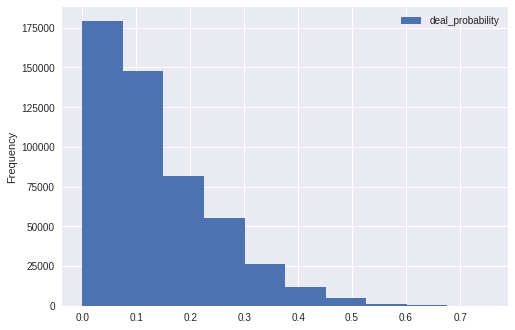

In [109]:
lgsub.plot.hist(bins = 10)

**Step 4 - Plot Feature Importance**
  * v1: image_top_1, price_log, svd_title_1/2/3

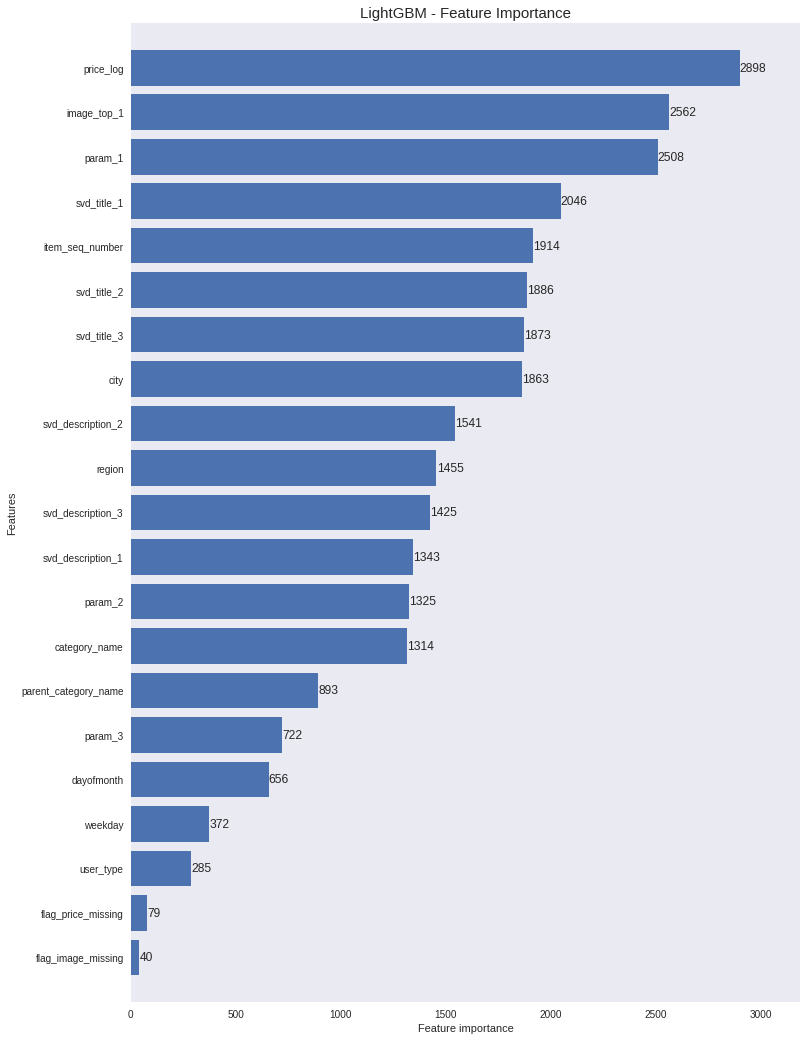

In [110]:
fig, ax = plt.subplots(figsize=(12,18))
lgb.plot_importance(model_final, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()